**Import Libraries:**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [17]:
import torch
import torchvision
import torch.nn as nn
from torch.utils.data import DataLoader
import torch.optim as optim
from torchvision import datasets, transforms
from matplotlib.pyplot import imshow, imsave
import matplotlib.pyplot as plt
import numpy as np


**Model:**

In [18]:
class ConvAE(nn.Module):
  def __init__(self):
    super(ConvAE, self).__init__()

    #Convolutional Encoder Layer structure based on:  http://richzhang.github.io/colorization/

                 # note that there are 3 grayscale channels going into the AE, 3 color out
                 # remember that stride 2 helps with image processing and removes need for pooling layer
    self.encoder = nn.Sequential(
                                                  # total size: divide by 2 for each due to stride and kernel size
        nn.Conv2d(3, 64, 4, stride=2, padding=1, bias=False), #  64*256*256 dimensions (channels, height, width)
        nn.BatchNorm2d(64),
        nn.LeakyReLU(0.2),

        nn.Conv2d(64, 128, 4, stride=2, padding=1, bias=False), # 128*128*128 dimensions (channels, height, width)
        nn.BatchNorm2d(128),
        nn.LeakyReLU(0.2),

        nn.Conv2d(128, 256, 4, stride=2, padding=1, bias=False), # 256*64*64 dimensions (channels, height, width)
        nn.BatchNorm2d(256),
        nn.LeakyReLU(0.2),

        nn.Conv2d(256, 512, 3, stride=1, padding=1, bias=False), # 512*64*64 dimensions (channels, height, width)
        nn.BatchNorm2d(512),
        nn.LeakyReLU(0.2),

        nn.Conv2d(512, 512, 4, stride=2, padding=1, bias=False), # 512*32*32 dimensions (channels, height, width)
        nn.BatchNorm2d(512),
        nn.LeakyReLU(0.2),

    )

    
    self.decoder = nn.Sequential(
        
        nn.ConvTranspose2d(512, 512, 4, stride=2, padding=1, bias=False),
        nn.BatchNorm2d(512),
        nn.LeakyReLU(0.2),
        
        nn.ConvTranspose2d(512, 512, 4, stride=2, padding=1, bias=False),
        nn.BatchNorm2d(512),
        nn.LeakyReLU(0.2),

        nn.ConvTranspose2d(512, 256, 4, stride=2, padding=1, bias=False),
        nn.BatchNorm2d(256),
        nn.LeakyReLU(0.2),
        
        nn.ConvTranspose2d(256, 3, 4, stride=2, padding=1, bias=False),
        nn.BatchNorm2d(3),
    )

    # feeding shortcut through seems to reduce reconstruction cost for weight updates
    self.shortcut = nn.Sequential(nn.BatchNorm2d(3),)
    self.out = nn.Sequential(nn.Sigmoid()) # output is a sigmoid to produce a logistic spread of img data
  
  def forward(self, x):
    #encoded = self.encoder(x)
    #decoded = self.decoder(encoded)
    #out = self.out(decoded + self.shortcut(x))
    return self.out(self.decoder(self.encoder(x)) + self.shortcut(x))



**Functions for Calling:**

In [19]:
def transform(train_dir,test_dir):
  train_trans = transforms.Compose([
                                  transforms.ToTensor(),
#using gaussian blur with large kernel to keep it from leaning lines (and face features) as much as color blurs to overlay. The residual part of the network should help with line weights and the encoder will just focus on color weights
                                  transforms.RandomRotation(30),
                                  transforms.RandomHorizontalFlip(),
                                  transforms.GaussianBlur(kernel_size=7)
                                  ]) 

  test_trans = transforms.Compose([transforms.ToTensor()])  

  train_data = datasets.ImageFolder(train_dir, transform=train_trans)
  test_data = datasets.ImageFolder(test_dir, transform=test_trans)
  return train_data,test_data

def fit_model(train_loader, test_loader, network, optimizer, criterion):
  network.train()
  for epoch in range(epochs):
    train_loss = 0
    test_loss = 0
    for data, target in train_loader:
      data, target = data.to(device), target.to(device)
      #gray = transforms.Grayscale(3)(data)
      logit = network(transforms.Grayscale(3)(data)) # grayscale input into network
      loss = criterion(logit, data) ## input gray training data and loss is against color training data. This should update the weights in favor of coloring the grayscale images
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      train_loss += loss.data
    
    scheduler.step()

    test_loss = 0
    network.eval()
    with torch.no_grad():
      for data, target in test_loader:
          data = data.to(device)
          #gray = transforms.Grayscale(3)(data)
          outputs = network(transforms.Grayscale(3)(data))
          loss = criterion(outputs, data) ## test loss needs to compare color and grayscale 
          test_loss += loss.data

    #saves & prints intermitten images and values through training 
    if (epoch == 0) or ((epoch+1) % 10 == 0):
        print(f"\ntrain epoch: {epoch+1}\ntrain loss: {train_loss/len(train_loader)}")
        print(f"test loss: {test_loss/len(test_loader)}")
        plot_image_reconstruction(network, img_loader, 1, {[0,epoch+1]}) 
    
def plot_image_reconstruction(network, imgs, img_num, idx):
     
     network.eval()
     for batch in imgs:
        
        img, _ = batch
        img = img.to(device)
        gray = transforms.Grayscale(3)(img)
        output = network(gray)
        
        output = output.view(output.size(0), 3, 512, 512).cpu().data
        plt.figure()
        f, axarr = plt.subplots(1,3)
        axarr[0].imshow(img.permute(0, 2, 3, 1).cpu()[img_num])
        axarr[1].imshow(gray.permute(0, 2, 3, 1).cpu()[img_num])
        axarr[2].imshow(output.permute(0, 2, 3, 1)[img_num])
        if idx[0] == 0: plt.title(f'Epoch number {idx[1]}')
        if idx[0] == 1: plt.title(f'Image Number {idx[1]}')
        break


**Settings for Network:**

In [20]:
train_dir = 'drive/MyDrive/face-HQ/train'
test_dir = 'drive/MyDrive/face-HQ/test'

## sample size 3000, train=2700, test=300
device = torch.device('cuda') ## not sure I need to use CPU at all but good to know ('cuda' if torch.cuda.is_available() else 'cpu')
## small batch size due to only 1 input, 1 output and 3000 samples
batch_size = 1 
learning_rate = 0.0001 
epochs = 100 

print_imgs =  16 ##sets up the print with images from test_loader data set (reloaded as img_loader)

network = ConvAE().to(device)  
optimizer = optim.Adam(network.parameters(),lr=learning_rate)
criterion = nn.MSELoss().to(device)   ## using MSE due to image reconstruction be about finding regression, not classifying
# note: gamma is set to 0.5 to prevent too large of change in the learning rate
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=np.linspace(20,100, 8), gamma=0.5)


train_data,test_data = transform(train_dir, test_dir)
train_loader = torch.utils.data.DataLoader(train_data, batch_size = batch_size,shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size = batch_size)
img_loader = torch.utils.data.DataLoader(test_data, batch_size = print_imgs)



**Load:**
Note that model, functions and settings have to be activated before loading weights

In [21]:
network.load_state_dict(torch.load( 'drive/MyDrive/face-HQ/model_save/Colorize_ConvAE2'))

<All keys matched successfully>

**Save Model Weights**

In [ ]:
torch.save(network.state_dict(), 'drive/MyDrive/face-HQ/model_save/Colorize_ConvAE2')

**Print Test Images:**

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:62: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


<Figure size 432x288 with 0 Axes>

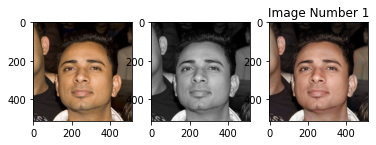

<Figure size 432x288 with 0 Axes>

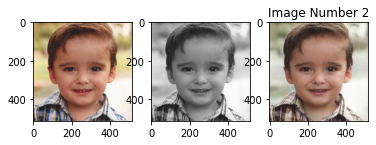

<Figure size 432x288 with 0 Axes>

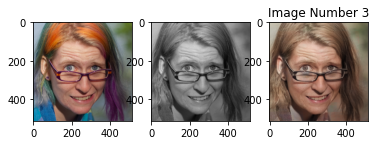

<Figure size 432x288 with 0 Axes>

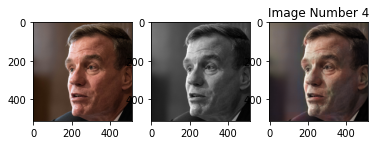

<Figure size 432x288 with 0 Axes>

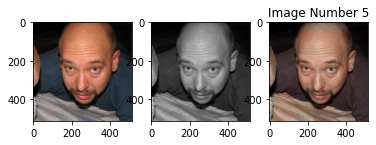

<Figure size 432x288 with 0 Axes>

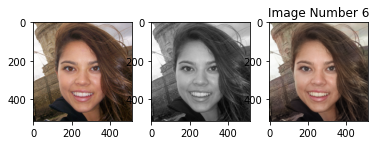

<Figure size 432x288 with 0 Axes>

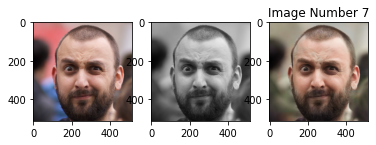

<Figure size 432x288 with 0 Axes>

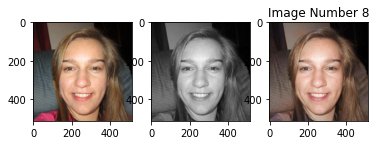

<Figure size 432x288 with 0 Axes>

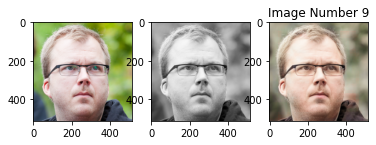

<Figure size 432x288 with 0 Axes>

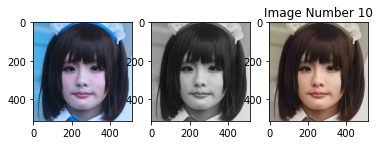

<Figure size 432x288 with 0 Axes>

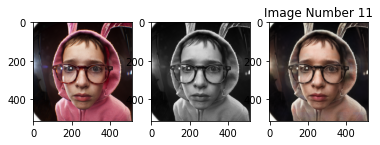

<Figure size 432x288 with 0 Axes>

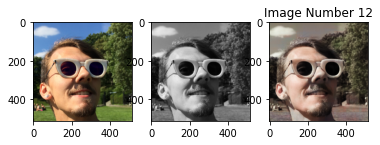

<Figure size 432x288 with 0 Axes>

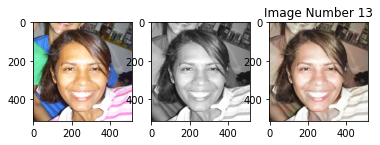

<Figure size 432x288 with 0 Axes>

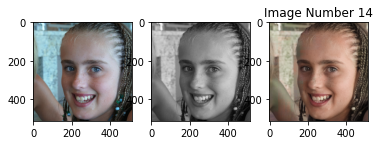

<Figure size 432x288 with 0 Axes>

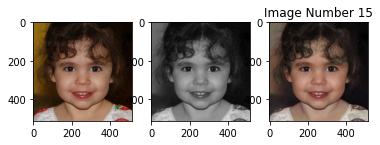

<Figure size 432x288 with 0 Axes>

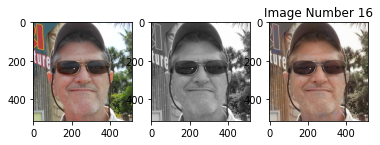

In [23]:
# note that the total photo limit is based on img_print size in 'settings'
for ii in range(print_imgs):
  plot_image_reconstruction(network, img_loader, img_num=ii, idx=[1,ii+1])

**Train Model:**
Only run if making modifications. If modified, make sure to save for later use

PRINT SETTINGS
BATCH SIZE: 1 
LR: 0.0001 
CRITERION: MSELoss() 
OPTIMIZER: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    eps: 1e-08
    foreach: None
    initial_lr: 0.0001
    lr: 0.0001
    maximize: False
    weight_decay: 0
) 
NETWORK: ConvAE(
  (encoder): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
    (3): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2)
    (6): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.2)
    (9): Conv2d(256, 512, kern

KeyboardInterrupt: ignored

<Figure size 432x288 with 0 Axes>

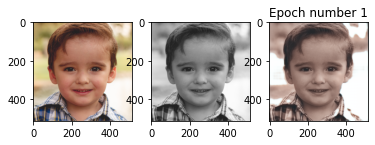

<Figure size 432x288 with 0 Axes>

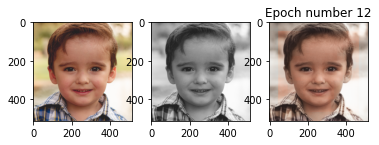

<Figure size 432x288 with 0 Axes>

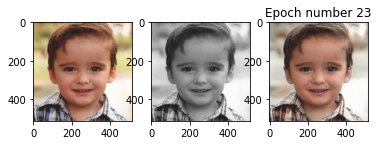

<Figure size 432x288 with 0 Axes>

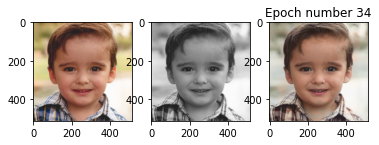

<Figure size 432x288 with 0 Axes>

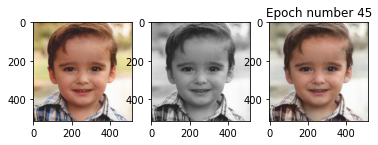

<Figure size 432x288 with 0 Axes>

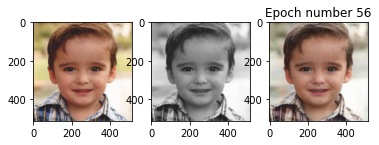

<Figure size 432x288 with 0 Axes>

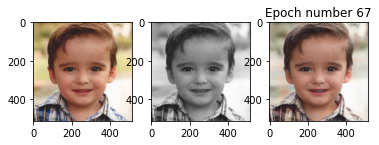

In [ ]:
print(f"PRINT SETTINGS\nBATCH SIZE: {batch_size} \nLR: {learning_rate} \nCRITERION: {criterion} \nOPTIMIZER: {optimizer} \nNETWORK: {network} ")
fit_model(train_loader, test_loader, network, optimizer, criterion)